In [24]:
import libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import yfinance as yf
import duckdb

import io
from urllib.request import urlopen
import zipfile
import os

from menuinst.platforms.win_utils.knownfolders import folder_path
from sipbuild.generator.parser.tokens import keywords

In [25]:
df = pd.read_csv("C:\dev\dm-2024-t1-pj-eda-honeybadgerlover645\eda\q1\\filter\stocks_to_keywords_specific\AAPL_apple.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date")

,GoldsteinScale,AvgTone,NumArticles,NumMentions,SOURCEURL,Date
2724,-2.0,1.075269,10.0,10.0,https://gulfnews.com/technology/consumer-elect...,1920-01-01
2727,6.0,-2.962963,3.0,3.0,https://www.thetimes.co.uk/edition/business/im...,1920-01-02
2728,6.0,1.063076,10.0,10.0,https://www.businessinsider.com.au/oneplus-pho...,1920-01-02
2729,8.0,4.633205,6.0,6.0,https://www.cnbc.com/2020/01/02/apple-signs-ex...,1920-01-02
2730,7.0,6.534091,5.0,5.0,http://www.startribune.com/apple-google-and-am...,1920-01-02
...,...,...,...,...,...,...
9819,3.0,-1.922269,70.0,70.0,https://www.forbes.com/sites/ewanspence/2024/1...,2024-10-14
9822,7.0,-1.011378,4.0,4.0,https://www.newsweek.com/apples-iphone-hits-sa...,2024-10-15
9820,3.0,5.054214,50.0,50.0,https://www.cnet.com/tech/mobile/apple-reporte...,2024-10-15
9821,1.0,-0.259067,2.0,2.0,https://www.abc.net.au/news/2024-10-15/malala-...,2024-10-15


In [49]:
start_date = '2018-01-01'
end_date = '2024-10-15'
full_date_range = pd.date_range(start_date, end_date)

In [ ]:
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [76]:
events_per_day = df.groupby('Date').size().reset_index(name='EventCount')
goldstein_per_day = df.groupby('Date')['GoldsteinScale'].sum().reset_index(name='GoldsteinScale')
avg_tone_per_day = df.groupby('Date')['AvgTone'].sum().reset_index(name='AvgTone')

In [87]:
df_full = pd.DataFrame({'Date': full_date_range}).merge(events_per_day, on='Date', how='left')
df_full = df_full.merge(goldstein_per_day, on='Date', how='left')
df_full = df_full.merge(avg_tone_per_day, on='Date', how='left')

df_full['EventCount'].fillna(0, inplace=True)
df_full['GoldsteinScale'].fillna(0, inplace=True)
df_full['AvgTone'].fillna(0, inplace=True)

df_full.set_index('Date', inplace=True)
df_full


,EventCount,GoldsteinScale,AvgTone
Date,,,
2018-01-01,0.0,0.0,0.000000
2018-01-02,0.0,0.0,0.000000
2018-01-03,1.0,-2.0,-6.666667
2018-01-04,1.0,7.0,-1.212121
2018-01-05,0.0,0.0,0.000000
...,...,...,...
2024-10-11,0.0,0.0,0.000000
2024-10-12,0.0,0.0,0.000000
2024-10-13,0.0,0.0,0.000000


In [91]:
df_full['GC'] = df_full['EventCount'] * df_full['GoldsteinScale']
df_full['AC'] = df_full['EventCount'] * df_full['AvgTone']

In [92]:
df_full['RollingAvg_Events'] = df_full['EventCount'].rolling(window='30D', min_periods=1).mean()
df_full['RollingAvg_GC'] = df_full['GC'].rolling(window='30D', min_periods=1).mean()
df_full['RollingAvg_AC'] = df_full['AC'].rolling(window='30D', min_periods=1).mean()

In [93]:
df_full['RollingAvg_Events'].fillna(0, inplace=True)
df_full['RollingAvg_GC'].fillna(0, inplace=True)
df_full['RollingAvg_AC'].fillna(0, inplace=True)

In [94]:

output = df_full

output

,EventCount,GoldsteinScale,AvgTone,GC,AC,RollingAvg_Events,RollingAvg_GC,RollingAvg_AC
Date,,,,,,,,
2018-01-01,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2018-01-02,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2018-01-03,1.0,-2.0,-6.666667,-2.0,-6.666667,0.000000,0.000000,0.000000
2018-01-04,1.0,7.0,-1.212121,7.0,-1.212121,0.000000,0.000000,0.000000
2018-01-05,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-11,0.0,0.0,0.000000,0.0,0.000000,2.366667,20.343333,3.124146
2024-10-12,0.0,0.0,0.000000,0.0,0.000000,2.266667,19.863333,3.540982
2024-10-13,0.0,0.0,0.000000,0.0,0.000000,2.166667,20.223333,3.070725


In [67]:
stocks = yf.download('AAPL', start=start_date, end=end_date, progress=False)
stocks

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.568928,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.561874,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.750271,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.214218,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.061142,82271200
...,...,...,...,...,...,...
2024-10-08,224.300003,225.979996,223.250000,225.770004,225.770004,31855700
2024-10-09,225.229996,229.750000,224.830002,229.539993,229.539993,33591100
2024-10-10,227.779999,229.500000,227.169998,229.039993,229.039993,28183500


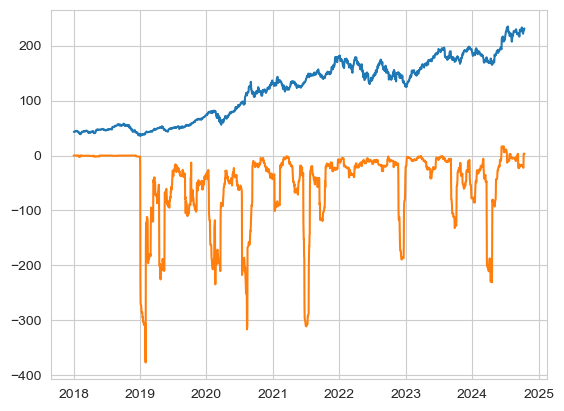

In [95]:
plt.plot(stocks.index, stocks.Close)
plt.plot(output.index, output.RollingAvg_AC)